In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from Bio import SeqIO
from Bio.SeqIO import SeqRecord
from Bio.Seq import Seq
from matplotlib import pyplot as plt

In [2]:
# Using the post-filtered data here. 
carboxylase_df = pd.read_csv('../annotree_data/PF00016_rubisco_large_042720_not_fIV.csv')
ms_df = pd.read_csv('../annotree_data/PF01274_malate_synthase_042720_filtered.csv')

In [3]:
carboxylase_orgs = set(carboxylase_df.gtdbId.unique())
ms_orgs = set(ms_df.gtdbId.unique())
overlap_orgs = carboxylase_orgs.intersection(ms_orgs)

carboxylase_df['has_malate_synthase'] = [r.gtdbId in ms_orgs for idx, r in carboxylase_df.iterrows()]

n_carboxylase_orgs = len(carboxylase_orgs)
n_with_ms = len(overlap_orgs)
pctage = 100*n_with_ms / n_carboxylase_orgs
print('%.1f%% of %d carboxylase-having organisms also have malate synthase' % (pctage, n_carboxylase_orgs))

49.7% of 2426 carboxylase-having organisms also have malate synthase


In [4]:
# Note -- annotree is r89 of GTDB as of 04/27/20
# Unfortunately these files have no header.
gtdb_taxonomy_bac = pd.read_csv('../gtdb/bac120_taxonomy_r89.tsv', sep='\t', header=None)
gtdb_taxonomy_arc = pd.read_csv('../gtdb/ar122_taxonomy_r89.tsv', sep='\t', header=None)
gtdb_taxonomy_bac.columns = ['gtdbId', 'taxonomy']
gtdb_taxonomy_arc.columns = ['gtdbId', 'taxonomy']
gtdb_taxonomy_bac.set_index('gtdbId', inplace=True)
gtdb_taxonomy_arc.set_index('gtdbId', inplace=True)

In [5]:
# Lookup the GTDB IDs in the taxonomy files
t_domain, t_phylum, t_class, t_order, t_family = [], [], [], [], [] 
for idx, row in carboxylase_df.iterrows():
    gtdb_id = row.gtdbId    
    bac_tax, arc_tax = None, None
    if gtdb_id in gtdb_taxonomy_bac.index:
        bac_tax = gtdb_taxonomy_bac.at[gtdb_id, 'taxonomy']
    if gtdb_id in gtdb_taxonomy_arc.index:
        arc_tax = gtdb_taxonomy_arc.at[gtdb_id, 'taxonomy']
    
    # Better have taxonomic information or something is up.
    tax = bac_tax or arc_tax
    assert tax is not None
    
    t_split = [t.split('__')[1] for t in tax.split(';')]
    t_domain.append(t_split[0])
    t_phylum.append(t_split[1])
    t_class.append(t_split[2])
    t_order.append(t_split[3])
    t_family.append(t_split[4])
carboxylase_df['domain'] = t_domain
carboxylase_df['phylum'] = t_phylum
carboxylase_df['class'] = t_class
carboxylase_df['order'] = t_order
carboxylase_df['family'] = t_family

# GTDB splits firmicutes and chloroflexi into multiple groups. I'm sure this is right, but will confuse many.
carboxylase_df['phylum_'] = [ph.split('_')[0] for ph in carboxylase_df.phylum]

In [6]:
phyla = ['Actinobacteriota', 'Firmicutes', 'Deinococcota',
         'Cyanobacteria', 'Desulfobacterota', 'Verrucomicrobiota',
         'Eremiobacterota', 'Gemmatimonadota', 'Dormibacterota']
classes = ['Alphaproteobacteria', 'Gammaproteobacteria']

n_carb_total = [carboxylase_df.gtdbId.unique().size]
n_ms_total = [carboxylase_df[carboxylase_df.has_malate_synthase].gtdbId.unique().size]


n_carb_phyla = []
n_ms_phyla = []
for ph in phyla:
    mask = carboxylase_df.phylum_ == ph
    unique_orgs = carboxylase_df[mask].gtdbId.unique().size
    
    has_ms_mask = mask & carboxylase_df.has_malate_synthase
    unique_orgs_with_ms = carboxylase_df[has_ms_mask].gtdbId.unique().size
    
    n_carb_phyla.append(unique_orgs)
    n_ms_phyla.append(unique_orgs_with_ms)
    
n_carb_class = []
n_ms_class = []
for cl in classes:
    mask = carboxylase_df['class'] == cl
    unique_orgs = carboxylase_df[mask].gtdbId.unique().size
    
    has_ms_mask = mask & carboxylase_df.has_malate_synthase
    unique_orgs_with_ms = carboxylase_df[has_ms_mask].gtdbId.unique().size
    
    n_carb_class.append(unique_orgs)
    n_ms_class.append(unique_orgs_with_ms)
    
plot_order = ['All results'] + classes + phyla
df_data = {'name': plot_order,
           'n_carboxylases': n_carb_total + n_carb_class + n_carb_phyla,
           'n_with_malate_synthase': n_ms_total + n_ms_class + n_ms_phyla}
plotting_df = pd.DataFrame(df_data)
plotting_df['pct_with_malate_syntase'] = 100*plotting_df.n_with_malate_synthase / plotting_df.n_carboxylases
plotting_df.set_index('name', inplace=True)

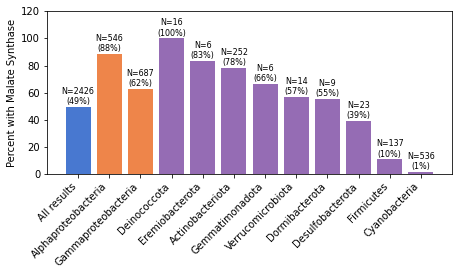

In [7]:
fig = plt.figure(figsize=(7.25, 3))
pal = sns.color_palette('muted')

colors = [pal[0]] + [pal[1]]*len(classes) + [pal[4]]*len(phyla)
bars = plotting_df.pct_with_malate_syntase.to_list()[:3]
all_names = plotting_df.index.to_list()
names = all_names[:3]
remaining_names = all_names[3:]
counts = plotting_df.n_carboxylases.to_list()[:3]

# sort phylum level values by percent.
phyla_sorted_df = plotting_df.loc[remaining_names].copy().sort_values('pct_with_malate_syntase', ascending=False)
bars += phyla_sorted_df.pct_with_malate_syntase.to_list()
names += phyla_sorted_df.index.to_list()
counts += phyla_sorted_df.n_carboxylases.to_list()

xs = np.arange(len(bars))
plt.bar(xs, bars, color=colors)
for x, y, count in zip(xs, bars, counts):
    plt.text(x, y+2, 'N=%d\n(%d%%)' % (count, y), ha='center', fontsize=8)

plt.xticks(xs, names, rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('Percent with Malate Synthase')
plt.ylim(0, 120)
plt.show()